In [15]:
import pandas as pd
from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [21]:
# Установить размер изображений
img_width, img_height = 150, 150

batch_size = 10

#путь к папке с изображениями
data_dir = 'symvols'

In [24]:
# Создаем пустой DataFrame для хранения информации об изображениях
image_df = pd.DataFrame(columns=['filename', 'label'])

# Загружаем все файлы изображений из папок классов символов и размечаем их
for label in os.listdir(data_dir):
    path = os.path.join(data_dir, label)
    for file in os.listdir(path):
        filename = os.path.join(path, file)
        new_row = pd.DataFrame({'filename': [filename], 'label': [label]})
        image_df = pd.concat([image_df, new_row], ignore_index=True)


In [26]:
#разделение датасета на тестовый и тренировочный набор
train_df = image_df.sample(frac=0.8, random_state=42)
test_df = image_df.drop(train_df.index)

In [27]:
# Создать аугментированные данные
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_df

,filename,label
2009,symvols\1\266.bmp,1
169,symvols\0\114 (2).bmp,0
1402,symvols\0\679.bmp,0
2126,symvols\1\372.bmp,1
10069,symvols\B\625.bmp,B
...,...,...
5330,symvols\5\458.bmp,5
4531,symvols\4\570.bmp,4
9866,symvols\B\442.bmp,B
365,symvols\0\200.bmp,0


In [33]:
# Создать генераторы изображений для тренировочного и тестового наборов
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='' ,
    x_col="filename",
    y_col="label",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical")

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='' ,
    x_col="filename",
    y_col="label",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical")

Found 12520 validated image filenames belonging to 21 classes.
Found 3130 validated image filenames belonging to 21 classes.


In [34]:
# Создать модель CNN
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(21, activation='softmax'))

# Скомпилировать модель с функцией потерь и метриками
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




In [36]:
# Обучить модель
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size
)
model.save('weights.h5')

Epoch 1/3
1252/1252 [==============================] - 156s 124ms/step - loss: 0.1067 - accuracy: 0.9715 - val_loss: 0.0394 - val_accuracy: 0.9923
Epoch 2/3
1252/1252 [==============================] - 156s 125ms/step - loss: 0.0444 - accuracy: 0.9895 - val_loss: 0.0389 - val_accuracy: 0.9911
Epoch 3/3
1252/1252 [==============================] - 158s 126ms/step - loss: 0.0403 - accuracy: 0.9895 - val_loss: 0.0364 - val_accuracy: 0.9920


In [56]:
labels = list(set(image_df["label"]))
labels.sort()
labels

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'E',
 'H',
 'K',
 'M',
 'P',
 'T',
 'X',
 'Y']

1/1 [==============================] - 0s 95ms/step
M


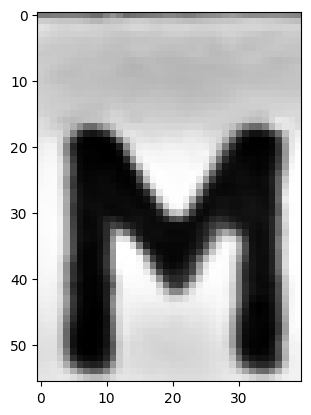

In [84]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Загрузить сохраненную модель
model = load_model('weights.h5')

# Загрузить изображение с помощью библиотеки Pillow
img_path = 'symvols\\M\\6.bmp'
img = image.load_img(img_path, target_size=(img_width, img_height))

# Преобразовать изображение в массив numpy
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Scaling pixel values in the range 0-1
x = x/255.0

# Получить предсказание
preds = model.predict(x)

#print(preds)
print(labels[np.argmax(preds)])
img = Image.open(img_path)
plt.imshow(img)


In [88]:
import os
from PIL import Image

def split_license_plate(image_path):
    # Открываем изображение
    image = Image.open(image_path)

    # Проверяем, что папка temp существует, если нет - создаем ее
    if not os.path.exists('temp'):
        os.makedirs('temp')

    # Разбиваем изображение на отдельные символы
    for i, char_image in enumerate(split_characters(image)):
        # Сохраняем каждый символ в папке temp
        char_image.save(os.path.join('temp', f'{i}.png'))

def split_characters(image):
    # Получаем размеры изображения
    image_width, image_height = image.size

    # Определяем размер отдельно взятого символа
    char_width = round(image_width / 10)
    char_height = round(image_height * 0.9)

    # Проходимся по каждому символу в номере машины
    for i in range(10):
        # Вычисляем координаты левого верхнего и правого нижнего углов символа в изображении
        left = i * char_width
        top = 0
        right = (i + 1) * char_width
        bottom = char_height

        # Вырезаем символ и создаем из него новое изображение
        char_image = image.crop((left, top, right, bottom)).copy()

        # Изменяем размер изображения до 32x32 (по необходимости)
        char_image = char_image.resize((32, 32))

        # Возвращаем символ
        yield char_image


In [91]:
split_license_plate("NumBaseCrop\\7.bmp")

In [99]:
import os
import cv2
import numpy as np
from keras.models import load_model

# Загружаем модель нейросети
model = load_model('weights.h5')

# Загружаем изображение номера машины
img_path = 'NumBaseCrop\\7.bmp'
img = cv2.imread(img_path)


split_license_plate("NumBaseCrop\\7.bmp")

# Склеиваем распознанные символы в одну строку
car_number = ''
symbols = os.listdir('temp')
for symbol in symbols[1:-3]:
    # Предобработка изображения символа для подготовки к распознаванию
    
    img = image.load_img('temp\\'+symbol, target_size=(img_width, img_height))
    
    # Преобразовать изображение в массив numpy
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Scaling pixel values in the range 0-1
    x = x/255.0

    # Получение распознанного символа от нейросети
    predicted = model.predict(x)
    car_number += labels[np.argmax(predicted)]

print('Номер машины: ', car_number)
print(labels)


1/1 [==============================] - 0s 29ms/step
Номер машины:  540555
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'E', 'H', 'K', 'M', 'P', 'T', 'X', 'Y']
